## Non-holonomic RRT 

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from matplotlib.lines import Line2D
import itertools
import shutil
import os

In [2]:
def empty_directory(path):
    if type(path) == list:
        for i in path:
            shutil.rmtree(i)
            os.mkdir(i)
    else:
        shutil.rmtree(path)
        os.mkdir(path)

In [61]:
class nonhn_RRT:
    def __init__(self,start_config,goal,v_init,w_init):
        (x0,y0,theta0) = start_config
        self.xg = goal[0]
        self.yg = goal[1]
        self.x = []
        self.y = []
        self.theta = []
        self.x.append(x0)
        self.y.append(y0)
        self.theta.append(theta0)
        self.vc = [] #platform centre v list
        self.wc = [] #platform centre w list
        self.vc.append(v_init)
        self.wc.append(w_init)
        
        # Limits
        self.x_lim = [0,100]
        self.y_lim = [0,100]
        
        self.d_max = 10
        self.del_t = 1
        
        # Defining Obstacles 
        
        ## Circle Obstacles
        self.circle_x = [20,90,75]
        self.circle_y = [20,70,85]
        self.radii = [7,2,5]
        
        ## Rectangular Obstacles 
        
        ### The vertices for each obstacle are given in the clockwise order starting from lower left
        self.obst_vertex_x = [40,40,60,60,70,70,85,85,40,40,60,60] 
        self.obst_vertex_y = [50,100,100,50,40,60,60,40, 0,38,38, 0]
        
        # Initialising Graph
        self.parent = []
        self.parent.append(0)
        
        
    
    def metric(self, i,j):
        (x1,y1)= (self.x[i],self.y[i])
        (x2,y2)= (self.x[j],self.y[j])
        px=(x1-x2)**(2)
        py=(y1-y2)**(2)
        metric = (px+py)**(0.5)
        return metric
    
    def add_node(self, n, new_x, new_y, new_theta, new_vc, new_wc):
        self.x.insert(n, new_x)
        self.y.insert(n, new_y)
        self.theta.insert(n, new_theta)
        self.vc.insert(n, new_vc)
        self.wc.insert(n, new_wc)
        return
    
    def remove_node(self, n):
        self.x.pop(n)
        self.y.pop(n)
        self.theta.pop(n)
        self.vc.pop(n)
        self.wc.pop(n)
        return
    
    def add_edge(self,parent,child):
        self.parent.insert(child,parent)
        return
    
    def near(self,n):
        dmin = self.metric(0,n)
        nnear = 0
        for i in range(0,n):
            if(self.metric(i,n)<dmin):
                dmin = self.metric(i,n)
                nnear = i
        return nnear
    
    def isInside(self,circle_x, circle_y, rad, x, y): # Checking if a point lies in a circle
 
        if ((x - circle_x) * (x - circle_x) + 
            (y - circle_y) * (y - circle_y) <= rad * rad): 
            return True; 
        else: 
            return False;
    
    def inobstacle(self,x1,y1,x2,y2):
        c=1 #assume no collision
        obs_num = len(self.obst_vertex_x)/4 
        for i in range(1,int(obs_num)+1): #Checking if the edge lies in one of the rectangles
            xomin=self.obst_vertex_x[4*(i-1)]
            xomax=self.obst_vertex_x[4*(i-1)+2]
            yomin=self.obst_vertex_y[4*(i-1)]
            yomax=self.obst_vertex_y[4*(i-1)+1]
            for j in range(0,101):
                u=j/100.0
                x=x1*u+x2*(1-u)
                y=y1*u+y2*(1-u)
                if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                    c=0
                    break
            if c==0:
                break
                
        if c==1: # If a collision hasnt occured with a rectangle
            for i in range(len(self.radii)):
                x1c = self.circle_x[i]
                y1c = self.circle_y[i]
                r = self.radii[i]
                for j in range(0,101):
                    u=j/100.0
                    x=x1*u+x2*(1-u)
                    y=y1*u+y2*(1-u)
                    if (self.isInside(x1c, y1c, r, x, y)): 
                        c=0
                        break
                if c == 0:
                    break
        return c
        
    def isfree(self): #check if new node lies inside obstacle
        n= len(self.x)-1
        (x,y)= (self.x[n], self.y[n]) 
        obs_num = len(self.obst_vertex_x)/4 #four vertices for each rectangular obstacle
        for i in range(1,int(obs_num)+1):
            xomin=self.obst_vertex_x[4*(i-1)]
            xomax=self.obst_vertex_x[4*(i-1)+2]
            yomin=self.obst_vertex_y[4*(i-1)]
            yomax=self.obst_vertex_y[4*(i-1)+1]
            if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                self.remove_node(n)
                return 0
                break
        for i in range(len(self.radii)): # For circle
            x1c = self.circle_x[i]
            y1c = self.circle_y[i]
            r = self.radii[i]
            if (self.isInside(x1c, y1c, r, x, y)): 
                self.remove_node(n)
                return 0
                break             
        return 1
    
    def nh_drive(self, nnear,n):
        del_t = self.del_t
        x0 = self.x[nnear]
        y0 = self.y[nnear]
        theta0 = self.theta[nnear]
        
        xgoal = self.x[n]
        ygoal = self.y[n]
        thetagoal = self.theta[n]
        
        v, w = [0.5, 6], [-math.pi/10, 0, math.pi/10]
        controls = list(itertools.product(v, w))
        
        max_dist = np.inf
        xfinal = 0
        yfinal = 0
        thetafinal = 0
        vbest = 0
        wbest = 0
#         print(len(controls))
        for i in controls:
            vtemp, wtemp = i[0], i[1]
            xnew = x0 + vtemp*del_t*math.cos(theta0 + wtemp*del_t)
            ynew = y0 + vtemp*del_t*math.sin(theta0 + wtemp*del_t)
             
            dist_from_goal = np.linalg.norm(np.array([xgoal,ygoal])-np.array([xnew,ynew]))
            
            if dist_from_goal < max_dist:
                xfinal = xnew
                yfinal = ynew
                thetafinal = (theta0 + wtemp*del_t)
                vbest = vtemp
                wbest = wtemp
                max_dist = dist_from_goal
        return xfinal, yfinal, thetafinal, vbest, wbest
    
    def connect(self, nnear, n, theta, vbest, wbest):
        d = self.metric(nnear,n)
        dmax = 10
        if(d>dmax):
            u=dmax/d
            (xnear,ynear)= (self.x[nnear],self.y[nnear])
            (x_n,y_n)= (self.x[n],self.y[n]) 
            (px,py)=(x_n-xnear,y_n-ynear)
            theta_des = self.theta[nnear] + wbest*del_t
            (x,y)=(xnear+vbest*self.del_t*math.cos(theta_des),ynear+vbest*self.del_t*math.sin(theta_des))
            self.remove_node(n)
            self.add_node(n,x,y,theta,vbest,wbest)
        
        (x1,y1)= (self.x[nnear],self.y[nnear])
        (x2,y2)= (self.x[n],self.y[n])
        
        if (self.inobstacle(x1,y1,x2,y2))==0:
            self.remove_node(n)
        else:
            self.parent.insert(n,nnear)
        
        return
    
    def expand_tree(self):
        x = random.uniform (self.x_lim[0], self.x_lim[1])
        y = random.uniform (self.y_lim[0], self.y_lim[1])
        theta = random.uniform(-math.pi, math.pi)
        
        n = len(self.x)
        self.add_node(n,x,y,theta,0,0)
        
        nnear = self.near(n)
        xfinal, yfinal, thetafinal, vbest, wbest = self.nh_drive(nnear,n)
        
        if (self.x_lim[0] <= xfinal <=  self.x_lim[1]) and (self.y_lim[0] <= yfinal <= self.y_lim[1]):
            
            if (self.isfree())!=0:
                self.remove_node(n)
                self.add_node(n,xfinal,yfinal,thetafinal,vbest,wbest)
                self.connect(nnear,n,theta,vbest,wbest)
                
        else:
            self.remove_node(n)
        
        return
    
    def path_to_goal(self):
        #find goal state
        tol = np.inf
        for i in range (0,len(self.x)):
            (x,y)= (self.x[i],self.y[i])
            if (np.linalg.norm(np.array([x-self.xg,y-self.yg])**2)<tol):
                
                tol = np.linalg.norm(np.array([x-self.xg,y-self.yg])**2)
                self.goalstate = i
                if(tol<5):
                    print("THE GOAL IS")
                    print(x,y)
                    break
                
        #add goal state to and its parent node to the path
        self.path=[]
        self.path.append(i)
        newpos=self.parent[i]
        
        #keep adding parents
        while (newpos!=0):
            self.path.append(newpos)
            newpos=self.parent[newpos]
            
        #add start state
        self.path.append(0)
    
    def showpath(self,k):
        n = len(self.path)-1
        self.centre_v = []
        self.lw_v = []
        self.w_list = []
        self.rw_v = []
        for i in range (len(self.path)-1):
            n = len(self.path)-1
            n1=self.path[n-i]
            n2=self.path[n-(i+1)]
            self.centre_v.append((self.vc[n2]))
            self.w_list.append((self.wc[n2]))
            plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],k,lw=1,markersize=3)
            plt.gca().set_aspect('equal', adjustable='box')
            name = 'nonholon_data/path/snap%s.png'%str(i)
            plt.savefig(name, dpi = 200)
     
    def ingoal(self):
        n= len(nn_RRT.x)-1
        (x,y)= (nn_RRT.x[n], nn_RRT.y[n])
        (xg,yg)= (self.xg, self.yg) 
        tol = 5
        if (np.linalg.norm(np.array([x-xg,y-yg])**2)<tol):
            return 1
        else:
            return 0

        
    def showtree(self, k):
        node_num = 0
        for i in range (0,len(self.x)):
            par=self.parent[i]
            plt.plot([self.x[i],self.x[par]],[self.y[i],self.y[par]],k,lw=0.5)
            plt.gca().set_aspect('equal', adjustable='box')
            if (i%1000==0):
                name = 'nonholon_data/tree/snap%s.png'%str(i)
                plt.savefig(name, dpi = 200)
    
    def draw(self):
        rbot = 2
        plt.plot([0-2*rbot,0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot],[0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot,0-2*rbot],'k',lw=0.5)
        plt.plot(self.xg,self.yg,'g*',markersize=20)
        plt.plot(0,2,'b*',markersize=20)
        
        self.test_env()
        self.showtree('0.15')
        self.showpath('bo-')

        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        return
    
    def test_env(self):
        """
        Function to generate test environment
        """
        
        obst_vertex_x = self.obst_vertex_x
        obst_vertex_y = self.obst_vertex_y
        for i in range(1,4): 
            x = obst_vertex_x[4*(i-1)]
            y = obst_vertex_y[4*(i-1)]
            width = obst_vertex_x[4*(i-1)+2] - obst_vertex_x[4*(i-1)]
            height = obst_vertex_y[4*(i-1)+2] - obst_vertex_y[4*(i-1)]
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)
           
        #centre positions of circular obstacles
        circle_x = self.circle_x
        circle_y = self.circle_y
        radii = self.radii

        for i in range(3): #plotting  circles
            circle = plt.Circle((circle_x[i],circle_y[i]),radii[i], color='r')
            plt.gca().add_patch(circle)
    
    def wheel_viz(self):
        b = 1.5
        lw_x = []
        lw_y = []
        rw_x = []
        rw_y = []
        centre_x = []
        centre_y = []
        theta_list = []
        lw_x.append(start_config[0])
        rw_x.append(start_config[0])
        lw_y.append(start_config[1]+b)
        rw_y.append(start_config[1]-b)
        centre_x.append(start_config[0])
        centre_y.append(start_config[1])
        theta_list.append(start_config[2])
        lw_v = []
        rw_v = []
        del_t = self.del_t
        rbot = 2
        xg = self.xg
        yg = self.yg
        
        for i in range(len(self.w_list)):

            lw_v.append(self.centre_v[i]-b*self.w_list[i])
            rw_v.append(self.centre_v[i]+b*self.w_list[i])

        for i in range(len(lw_v)):
            theta_cur = theta_list[-1]+self.w_list[i]*del_t

            centre_x_cur = centre_x[-1]+self.centre_v[i]*del_t*np.cos(theta_cur)
            centre_y_cur = centre_y[-1]+self.centre_v[i]*del_t*np.sin(theta_cur)
            lw_x_cur = centre_x_cur - b*np.sin(theta_cur)
            lw_y_cur = centre_y_cur + b**np.cos(theta_cur)
            rw_x_cur = centre_x_cur + b*np.sin(theta_cur)
            rw_y_cur = centre_y_cur - b*np.cos(theta_cur) 

            theta_list.append(theta_cur)
            lw_x.append(lw_x_cur)
            rw_x.append(rw_x_cur)
            lw_y.append(lw_y_cur)
            rw_y.append(rw_y_cur)
            centre_x.append(centre_x_cur)
            centre_y.append(centre_y_cur)

        for j in range(len(lw_y)):
            plt.plot([0-2*rbot,0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot],[0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot,0-2*rbot],'k',lw=0.5)

            plt.plot(xg,yg,'g*',markersize=20)

            num = len(self.obst_vertex_x)/4
            for i in range(1,int(num)+1): # Plotting rectangles
                x = self.obst_vertex_x[4*(i-1)] +2*rbot
                y = self.obst_vertex_y[4*(i-1)]+2*rbot
                width = self.obst_vertex_x[4*(i-1)+2] - self.obst_vertex_x[4*(i-1)] - 4*rbot
                height = self.obst_vertex_y[4*(i-1)+2] - self.obst_vertex_y[4*(i-1)] - 4*rbot
                rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
                plt.gca().add_patch(rect)

            for i in range(len(self.radii)):
                circle = plt.Circle((self.circle_x[i],self.circle_y[i]),self.radii[i]-2*rbot, color='r')
                plt.gca().add_patch(circle)
                
            plt.plot(lw_x[:j],lw_y[:j],'r--')
            plt.plot(rw_x[:j],rw_y[:j],'b--')
            plt.plot(centre_x[:j],centre_y[:j],'k-')
            colors = ['red', 'blue']
            lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
            labels = ['left wheel', 'right wheel']
            plt.legend(lines, labels)

            plt.gca().set_aspect('equal', adjustable='box')
            name = 'nonholon_data/wheel/snap%s.png'%str(j)
            plt.savefig(name, dpi = 200)
        return

0
1000
2000
3000
4000
THE GOAL IS
98.11962256777183 99.27002645832842


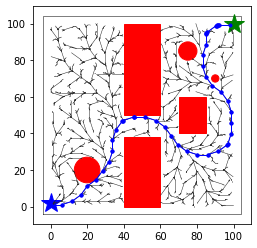

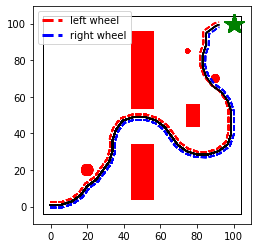

In [63]:
goal = (100,100)
start_config =(0,1,0)
vinit = 5
winit = 0.1
nn_RRT = nonhn_RRT(start_config,goal,vinit,winit)

empty_directory(['./nonholon_data/path','./nonholon_data/tree','./nonholon_data/wheel'])
for i in range(0,5000):
    if (i%1000==0):
        print(i)
    nn_RRT.expand_tree()
        
nn_RRT.path_to_goal()
nn_RRT.draw()
nn_RRT.wheel_viz()

0
1000
2000
3000
4000
THE GOAL IS
97.8708149135003 98.85472104176576


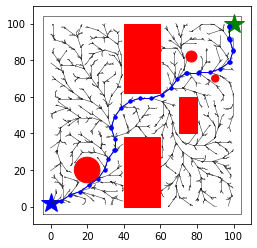

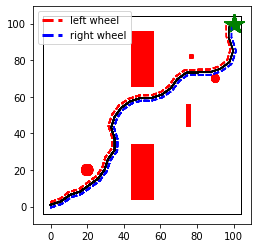

In [59]:
goal = (100,100)
start_config =(0,1,0)
vinit = 5
winit = 0.1
nn_RRT = nonhn_RRT(start_config,goal,vinit,winit)

empty_directory(['./nonholon_data/path','./nonholon_data/tree','./nonholon_data/wheel'])
for i in range(0,5000):
    if (i%1000==0):
        print(i)
    nn_RRT.expand_tree()
        
nn_RRT.path_to_goal()
nn_RRT.draw()
nn_RRT.wheel_viz()